In [1]:
import gd
import numpy as np
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

dataset = "mushrooms.txt" 
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
n, d = X.shape
y = 2*y-3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

L = np.max(np.linalg.eigvals(X.T @ X )).real/n
lambda_value = L/100
L


5.26

[1e-08, 1e-06, 0.0001, 0.01, 1.0, 100.0, 10000.0, 1000000.0, 100000000.0, 10000000000.0]
300


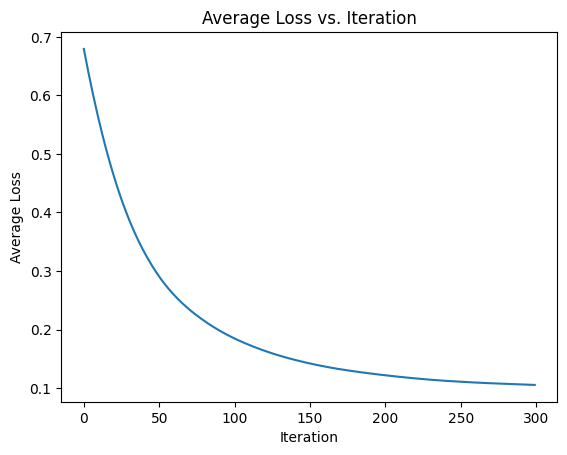

0.10539735219577394

In [13]:

def loss(w, X, y, lambda_value):
    yXw = y * (X @ w)
    log_loss = np.mean(np.log(1 + np.exp(-yXw)))
    reg_loss = (lambda_value / 2) * np.dot(w, w)
    return log_loss + reg_loss

def loss_grad(w, X, y, lambda_value):
    yXw = y * (X @ w)
    log_grad = np.mean((-y * X.T)/(1+np.exp(+yXw)), axis=1)
    reg_grad = lambda_value * w
    return log_grad + reg_grad

f = gd.Func(
    func=loss,
    grad=loss_grad
)

def batch_generator(X, y, batch_size):
    n_samples = X.shape[0]
    for i in range(0, n_samples, batch_size):
        yield (X[i:i + batch_size], y[i:i + batch_size])

workers = []
batch_size = 500
for X_batch, y_batch in batch_generator(X_train, y_train, batch_size):
    worker_func = gd.create_worker_func(f, X_batch, y_batch, lambda_value)
    workers.append(gd.Worker(worker_func))

def top_k(k, arr):
    new_arr = arr.copy()
    new_arr[arr < np.sort(arr)[-k]] = 0
    return new_arr

def generate_alpha_sequence(n, start=0.01, factor=2):
    return [start * (factor ** k) for k in range(n)]

def general_biased_rounding(x, alpha_sequence):
    # Оператор общего смещенного округления для вектора x
    C_x = np.zeros_like(x)  # Инициализация вектора округленных значений
    for i, x_i in enumerate(x):
        # Поиск ближайшего элемента t из alpha_sequence к |x_i|
        t_min = min(alpha_sequence, key=lambda t: abs(t - abs(x_i)))
        C_x[i] = np.sign(x_i) * t_min
    return C_x

alpha_sequence = generate_alpha_sequence(10, 1e-8, 100)
print(alpha_sequence)

for worker in workers:
    worker.compress_op = lambda arr: general_biased_rounding(arr, alpha_sequence)
    pass

dgd = gd.DistributedGD(workers, 2/(L+lambda_value))
w0 = np.zeros(d)  # Начальная инициализация весов
dgd.run(300, w0)  # Запускаем 100 итераций

loss_history = [loss(w, X_train, y_train, 0) for w in dgd.history]
# Строим график средней функции потерь
plt.plot([loss(w, X_train, y_train, 0) for w in dgd.history])
print(len(dgd.history))
plt.xlabel('Iteration')
plt.ylabel('Average Loss')
plt.title('Average Loss vs. Iteration')
plt.show()
min(loss_history)

In [8]:
A = np.array([[1,2], [3,4], [6,5]])
y = np.array([1, 1, -1])
A = A[:1]
y = y[:1]
np.mean([[1,2], [1,2], [1,5]], axis=0)

def top_k(k, arr):
    arr[arr < np.sort(arr)[-k]] = 0

arr = np.array([1, 2, 2, 2, 2, 2])
top_k(2, arr)
arr
alpha_sequence = generate_alpha_sequence(20, 1e-8, 5)
print(alpha_sequence)

[1e-08, 5e-08, 2.5e-07, 1.25e-06, 6.25e-06, 3.125e-05, 0.00015625, 0.00078125, 0.00390625, 0.01953125, 0.09765625, 0.48828125, 2.44140625, 12.20703125, 61.03515625, 305.17578125, 1525.87890625, 7629.39453125, 38146.97265625, 190734.86328125]
